In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math
import json
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm


from utils import *
from autoencoder import Autoencoder
from diffusion_networks import *
from sampler import *
from calculations import *

In [2]:
# Defining the constants and configurations used throughout the notebook.
k = 100
batch_size = 256 # 256 Largest possible batch size that fits on the GPU w.f32
on_remote = False
spacing = 10

iterations = 2101000
spinup = 1001
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')

#ae-2ds-32f-1l-150e-L1-0wd-0.00001l1
mean_data_latent = -0.6132266521453857
std_data_latent = 5.066834926605225
std_residual_latent =5.375336170196533

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def residual_scaling(x):
    p1, p2, p3 = (6.35897732,  0.05893581, 20.30253434)
    return p1 / (1 + torch.exp(-p2 * (x - p3)))

# Data Loading

In [4]:
# Fixed k sampling
train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
#test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
shuffled_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Fixed k sampling
kmin = 50
kmax = 150
d = 1

val_time_series_dataset = TimeSeriesDataset(data_path, 'val', p_train, kmin, kmax, d, spinup, spacing, iterations, mean_data, std_data, device)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

In [6]:
# Randomized k sampling
kmin = 50
kmax = 150
d = 1

k_update_callback = update_k_per_batch

train_time_dataset = TimeSampleDataset(data_path, 'train', p_train, kmax, spinup, spacing, iterations, mean_data, std_data, device)
val_time_dataset = TimeSampleDataset(data_path, 'val', p_train, kmax, spinup, spacing, iterations, mean_data, std_data, device)

train_batch_sampler = DynamicKBatchSampler(train_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=k_update_callback, shuffle=True, kmin=kmin, d=d)
val_batch_sampler = DynamicKBatchSampler(val_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=k_update_callback, kmin=kmin, d=d)

train_time_loader = DataLoader(train_time_dataset, batch_sampler=train_batch_sampler)
val_time_loader = DataLoader(val_time_dataset, batch_sampler=val_batch_sampler)


In [7]:
# Numerical model
n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)

# Load Models

In [7]:
# Load Autoencoder
autoencoder_date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{autoencoder_date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{autoencoder_date}/{autoencoder_model}/')
saved_model = torch.load(autoencoder_path / 'best_model.pth')

with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)
autoencoder.load_state_dict(saved_model)
autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [7]:
# Load Diffusion model
diffusion_date = '2024-02-29'
result_model = f'ncsnpp-f32-k{k}'

result_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{diffusion_date}/{result_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{diffusion_date}/{result_model}/')
saved_model = torch.load(result_path / 'best_model.pth')

with open(result_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
model_name = parameters['model']
k = parameters['k']

forecasting = True
model = GCPrecond(filters=filters, img_channels=2 if forecasting else 1, model='ncsnppOriginal', img_resolution = 16, time_emb=0)

model.load_state_dict(saved_model)
model.to(device)
model.eval()
print("Diffusion Model loaded successfully!")

Diffusion Model loaded successfully!


### Scaling function

In [ ]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for current, next in train_loader:
            # Get the input data from the batch
            latent = autoencoder.encoder(current)
            next_latent = autoencoder.encoder(next)
            
            inputs = next_latent -  latent

            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        #print("Mean:", mean_data_latent.item())
        #print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent, std_residual_latent)

In [ ]:
# Fit the residual scaling
ks = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
stds = []
for k in ks:
    train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    _, std_latent_k = calculate_latent_mean_std()
    stds.append(std_latent_k.item())
    print(k, std_latent_k.item())

from scipy.optimize import curve_fit

# Defining the models
def log_model(x, a, b, c):
    return a + b * np.log(x + c)  # Added c to avoid log(0) when x is 0

def logistic_model(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))


x = ks[1:]
y = stds[1:]

# Initial guess for the parameters
initial_guess_log = [1, 1, 1]
initial_guess_logistic = [max(y), 0.01, 50]

# Fitting the models to the data
params_log, params_covariance_log = curve_fit(log_model, x, y, p0=initial_guess_log)
params_logistic, params_covariance_logistic = curve_fit(logistic_model, x, y, p0=initial_guess_logistic, maxfev=10000)

# Generating fitted values
y_fitted_log = log_model(x, *params_log)
y_fitted_logistic = logistic_model(x, *params_logistic)

# Plotting the original data and the fitted models
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_fitted_log, color='red', label='Log Model')
plt.plot(x, y_fitted_logistic, color='green', label='Logistic Model')
plt.title('Data Points with Fitted Models')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()


# Training Diffusion

### Sampling for training (Change)

In [ ]:
def sample_and_plot(net, class_labels = None, img_channels=1):
    sampler_fn = complete_edm_sampler
    
    latents = torch.randn([1, img_channels, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

    # TODO Fix such that you can plot smaller resolutions
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()
    
sample_and_plot(model, img_channels=2)

In [ ]:
def plot_forecasts_from_residual(model, num_images=4):
    for previous, current in train_loader:
        with torch.no_grad():
            previous_latent = autoencoder.encoder(previous)
        
        previous_latent = previous_latent[0].unsqueeze(0)
        break

    img_channels = previous_latent.size(1)
    class_labels = previous_latent.repeat(num_images, 1, 1, 1)

    sampler_fn = edm_sampler
    latents = torch.randn([num_images, img_channels, model.img_resolution, model.img_resolution], device=device)
    
    residuals = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

    predicted_latent = previous_latent + residuals * std_residual_latent

    predicted = autoencoder.decoder(predicted_latent.to(torch.float32)).cpu().detach().numpy()[:,0]
    previous = previous[0,0].cpu().detach().numpy()
    current = current[0,0].cpu().detach().numpy()

    vmin = min(predicted.min(), current.min(), previous.min())
    vmax = max(predicted.max(), current.max(), previous.max())

    fig, axes = plt.subplots(1, 2+num_images, figsize=(15, 5))

    axes[0].imshow(previous, vmin=vmin, vmax=vmax)
    axes[0].axis('off')
    axes[0].set_title('Previous')

    axes[1].imshow(current, vmin=vmin, vmax=vmax)
    axes[1].axis('off')
    axes[1].set_title('Truth')

    for i in range(num_images):
        axes[i+2].imshow(predicted[i], vmin=vmin, vmax=vmax)
        axes[i+2].axis('off')
        axes[i+2].set_title('Sampled')

    plt.tight_layout()
    plt.show()

plot_forecasts_from_residual(model)

### Training (Change)

In [217]:
# Setup for training

forecasting = True

num_epochs = 10

model = GCPrecond(filters=32, img_channels=2 if forecasting else 1, img_resolution = 16, time_emb=1)#, model='simple')
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
#optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
loss_fn = GCLoss(time_noise=0)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=100)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  3402721


In [19]:

print(model.model)

TimeSongUNet(
  (map_noise): FourierEmbedding()
  (map_layer0): Linear()
  (map_layer1): Linear()
  (map_time): FourierEmbedding()
  (enc): ModuleDict(
    (16x16_conv_2_32): Conv2d(cin=2, cout=32)
    (16x16_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d(cin=32, cout=64)
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d(cin=64, cout=64)
      (skip): Conv2d(cin=32, cout=64)
    )
    (16x16_block1): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d(cin=64, cout=64)
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d(cin=64, cout=64)
    )
    (16x16_block2): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d(cin=64, cout=64)
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d(cin=64, cout=64)
    )
    (16x16_block3): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d(cin=64, cout=64)
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d(cin=64, cou

In [218]:
model.load_state_dict(torch.load('240411wd0.01cont.pth'))

<All keys matched successfully>

 15%|█▌        | 100/656 [00:42<04:03,  2.28it/s]

Average Loss: 59.4306


 30%|███       | 200/656 [01:39<04:24,  1.72it/s]

Average Loss: 60.1465


 46%|████▌     | 300/656 [02:37<03:26,  1.72it/s]

Average Loss: 60.0265


 61%|██████    | 400/656 [03:35<02:28,  1.72it/s]

Average Loss: 59.0620


 76%|███████▌  | 500/656 [04:33<01:30,  1.72it/s]

Average Loss: 59.9336


 91%|█████████▏| 600/656 [05:31<00:32,  1.72it/s]

Average Loss: 58.6276


100%|██████████| 81/81 [00:28<00:00,  2.82it/s]


Epoch [1/10], Average Loss: 59.6219, Validation Loss: 58.2571
Training time: 364.30572s, Validation time: 28.76164s, Sample time: 0.00000s


 15%|█▌        | 100/656 [00:57<05:23,  1.72it/s]

Average Loss: 58.9624


 30%|███       | 200/656 [01:55<04:24,  1.72it/s]

Average Loss: 58.2348


 46%|████▌     | 300/656 [02:53<03:26,  1.72it/s]

Average Loss: 58.7531


 61%|██████    | 400/656 [03:51<02:28,  1.73it/s]

Average Loss: 60.0502


 76%|███████▌  | 500/656 [04:50<01:30,  1.72it/s]

Average Loss: 58.8490


 91%|█████████▏| 600/656 [05:48<00:32,  1.73it/s]

Average Loss: 60.9446


100%|██████████| 81/81 [00:28<00:00,  2.85it/s]


Epoch [2/10], Average Loss: 59.2489, Validation Loss: 58.1189
Training time: 380.92741s, Validation time: 28.40489s, Sample time: 0.00000s


 15%|█▌        | 100/656 [00:57<05:22,  1.72it/s]

Average Loss: 58.3352


 30%|███       | 200/656 [01:55<04:24,  1.72it/s]

Average Loss: 59.9934


 46%|████▌     | 300/656 [02:53<03:26,  1.72it/s]

Average Loss: 59.2472


 61%|██████    | 400/656 [03:51<02:28,  1.72it/s]

Average Loss: 58.8989


 76%|███████▌  | 500/656 [04:50<01:40,  1.55it/s]

Average Loss: 57.7689


 91%|█████████▏| 600/656 [05:51<00:32,  1.72it/s]

Average Loss: 57.5247


100%|██████████| 81/81 [00:28<00:00,  2.88it/s]


Epoch [3/10], Average Loss: 58.5764, Validation Loss: 58.0622
Training time: 384.32927s, Validation time: 28.12652s, Sample time: 0.00000s


 15%|█▌        | 100/656 [00:57<05:22,  1.72it/s]

Average Loss: 59.8525


 30%|███       | 200/656 [01:55<04:24,  1.72it/s]

Average Loss: 58.9510


 46%|████▌     | 300/656 [02:53<03:26,  1.72it/s]

Average Loss: 59.8726


 61%|██████    | 400/656 [03:52<02:28,  1.72it/s]

Average Loss: 58.7786


 76%|███████▌  | 500/656 [04:50<01:30,  1.72it/s]

Average Loss: 59.5102


 91%|█████████▏| 600/656 [05:48<00:32,  1.72it/s]

Average Loss: 57.8418


100%|██████████| 81/81 [00:28<00:00,  2.84it/s]


Epoch [4/10], Average Loss: 59.1678, Validation Loss: 58.2042
Training time: 380.67386s, Validation time: 28.53124s, Sample time: 0.00000s


 15%|█▌        | 100/656 [00:57<05:22,  1.72it/s]

Average Loss: 58.1371


 30%|███       | 200/656 [01:55<04:24,  1.72it/s]

Average Loss: 57.8067


 46%|████▌     | 300/656 [02:53<03:26,  1.72it/s]

Average Loss: 60.1791


 61%|██████    | 400/656 [03:52<02:28,  1.72it/s]

Average Loss: 58.5154


 76%|███████▌  | 500/656 [04:50<01:30,  1.72it/s]

Average Loss: 56.8260


 91%|█████████▏| 600/656 [05:48<00:32,  1.72it/s]

Average Loss: 59.0137


100%|██████████| 81/81 [00:27<00:00,  2.94it/s]


Epoch [5/10], Average Loss: 58.2762, Validation Loss: 57.8505
Training time: 380.65589s, Validation time: 27.56403s, Sample time: 0.00000s


 15%|█▌        | 100/656 [00:57<05:22,  1.72it/s]

Average Loss: 58.6854


 30%|███       | 200/656 [01:55<04:24,  1.72it/s]

Average Loss: 57.3256


 46%|████▌     | 300/656 [02:54<03:26,  1.72it/s]

Average Loss: 57.9001


 61%|██████    | 400/656 [03:52<02:28,  1.72it/s]

Average Loss: 58.6524


 76%|███████▌  | 500/656 [04:50<01:30,  1.72it/s]

Average Loss: 57.8985


 91%|█████████▏| 600/656 [05:48<00:32,  1.72it/s]

Average Loss: 57.9475


100%|██████████| 81/81 [00:28<00:00,  2.87it/s]


Epoch [6/10], Average Loss: 58.1910, Validation Loss: 58.2773
Training time: 381.16210s, Validation time: 28.22628s, Sample time: 0.00000s


 15%|█▌        | 100/656 [00:57<05:22,  1.72it/s]

Average Loss: 58.6864


 30%|███       | 200/656 [01:55<04:24,  1.72it/s]

Average Loss: 58.1052


 46%|████▌     | 300/656 [02:53<03:26,  1.72it/s]

Average Loss: 59.9548


 61%|██████    | 400/656 [03:52<02:28,  1.72it/s]

Average Loss: 57.3167


 76%|███████▌  | 500/656 [04:50<01:30,  1.72it/s]

Average Loss: 57.9876


 91%|█████████▏| 600/656 [05:48<00:32,  1.72it/s]

Average Loss: 57.2540


100%|██████████| 81/81 [00:27<00:00,  2.90it/s]


Epoch [7/10], Average Loss: 58.2861, Validation Loss: 57.0161
Training time: 380.65365s, Validation time: 28.01997s, Sample time: 0.00000s


 15%|█▌        | 100/656 [00:57<05:22,  1.72it/s]

Average Loss: 57.3378


 30%|███       | 200/656 [01:55<04:24,  1.72it/s]

Average Loss: 57.2917


 46%|████▌     | 300/656 [02:54<03:26,  1.72it/s]

Average Loss: 58.3790


 61%|██████    | 400/656 [03:52<02:28,  1.72it/s]

Average Loss: 57.9987


 76%|███████▌  | 500/656 [04:50<01:30,  1.72it/s]

Average Loss: 57.9998


 91%|█████████▏| 600/656 [05:48<00:32,  1.72it/s]

Average Loss: 58.3084


100%|██████████| 81/81 [00:27<00:00,  2.92it/s]


Epoch [8/10], Average Loss: 57.8035, Validation Loss: 56.3667
Training time: 380.76601s, Validation time: 27.79663s, Sample time: 0.00000s


 15%|█▌        | 100/656 [00:57<05:22,  1.72it/s]

Average Loss: 57.3302


 30%|███       | 200/656 [01:55<04:24,  1.72it/s]

Average Loss: 57.6340


 46%|████▌     | 300/656 [02:54<03:26,  1.72it/s]

Average Loss: 56.6154


 61%|██████    | 400/656 [03:52<02:28,  1.72it/s]

Average Loss: 57.2669


 76%|███████▌  | 500/656 [04:51<01:32,  1.68it/s]

Average Loss: 58.0992


 91%|█████████▏| 600/656 [05:50<00:33,  1.68it/s]

Average Loss: 56.9373


100%|██████████| 81/81 [00:31<00:00,  2.60it/s]


Epoch [9/10], Average Loss: 57.3759, Validation Loss: 56.9882
Training time: 383.92943s, Validation time: 31.17309s, Sample time: 0.00000s


 15%|█▌        | 100/656 [01:02<05:33,  1.67it/s]

Average Loss: 58.1417


 30%|███       | 200/656 [02:04<04:30,  1.68it/s]

Average Loss: 57.8389


 46%|████▌     | 300/656 [03:03<03:03,  1.94it/s]

Average Loss: 57.8020


 61%|██████    | 400/656 [04:00<02:12,  1.93it/s]

Average Loss: 59.0562


 76%|███████▌  | 500/656 [04:56<01:34,  1.65it/s]

Average Loss: 56.6453


 91%|█████████▏| 600/656 [05:57<00:33,  1.68it/s]

Average Loss: 58.3329


100%|██████████| 81/81 [00:32<00:00,  2.50it/s]


Epoch [10/10], Average Loss: 58.0308, Validation Loss: 57.0864
Training time: 397.52271s, Validation time: 32.38249s, Sample time: 0.00100s


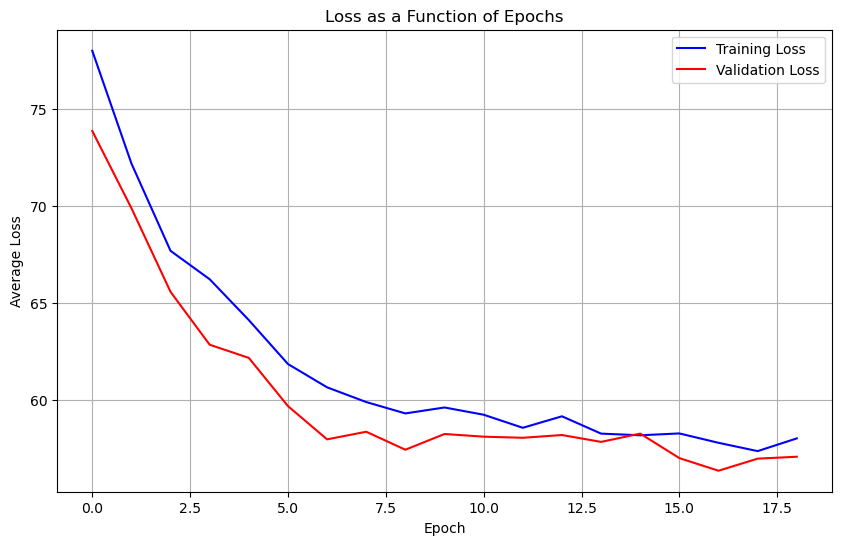

In [20]:
# Training time dependent model
# Training
import time
from tqdm import tqdm

# Training loop

log_interval = 100#len(train_loader) // 4

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    current_loss = 0
    count = 0


    for previous, current, time_label in tqdm(train_time_loader):
        current = current.to(device)
        previous = previous.to(device)
        
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / residual_scaling(time_label[0]) #std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
        
        time_label = time_label/kmax
        loss = loss_fn(model, target_latent, previous_latent, time_label.to(torch.float32))

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            # Calculate and log the current average loss
            current_loss = current_loss / count

            print(f'Average Loss: {current_loss:.4f}')

            current_loss = 0
            count = 0
        warmup_scheduler.step()

            
    avg_train_loss = total_train_loss / len(train_time_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current, time_label in tqdm(val_time_loader):
            current = current.to(device)
            previous = previous.to(device)
            
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / residual_scaling(time_label[0])
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
            time_label = time_label/kmax
            loss = loss_fn(model, target_latent, previous_latent, time_label)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_time_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    
    scheduler.step()
        
    if forecasting:
        #plot_ensemble(model)
        #plot_forecasts_from_residual(model)
        pass
    else:
        pass
        #sample_and_plot(model, img_channels=1)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')
    torch.save(model.state_dict(), 'final_model.pth')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
# Evaluate loss for specific k
k = 50

val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model.eval()  # Set model to evaluation mode
total_val_loss = 0
with torch.no_grad():
    for previous, current in (val_loader):
        current_latent = autoencoder.encoder(current)
        previous_latent = None

        time_label = torch.ones((previous.shape[0]), device=device, dtype=int) * k
        if forecasting:
            previous_latent = autoencoder.encoder(previous)
            target_latent = (current_latent - previous_latent) / residual_scaling(time_label[0])
        else:
            target_latent = (current_latent - mean_data_latent) / std_data_latent
        loss = loss_fn(model, target_latent, previous_latent, time_label/kmax)
        #print(time_label[0].item(), f'{loss.item():.2f}')
        
        total_val_loss += loss.item()
        
avg_val_loss = total_val_loss / len(val_loader)
avg_val_loss

48.31069431534733

In [ ]:
# Training fixed k
import time
from tqdm import tqdm

# Training loop

log_interval = 100#len(train_loader) // 4

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    current_loss = 0
    count = 0

    for previous, current in tqdm(train_loader):
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
        loss = loss_fn(model, target_latent, previous_latent)

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            # Calculate and log the current average loss
            current_loss = current_loss / count

            print(f'Average Loss: {current_loss:.4f}')

            current_loss = 0
            count = 0
        
        warmup_scheduler.step()

            
    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in tqdm(val_loader):
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
            loss = loss_fn(model, target_latent, previous_latent)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    
    scheduler.step()
        
    if forecasting:
        #plot_ensemble(model)
        #plot_forecasts_from_residual(model)
        pass
    else:
        pass
        #sample_and_plot(model, img_channels=1)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')
    torch.save(model.state_dict(), 'final_model.pth')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

# Generation

In [191]:
def generate_ensemble_from_single_random(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler):
    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0)
        current_unbatched = current[0].unsqueeze(0)
        break


    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(n_ens, device=device, dtype=int) * k / kmax

        latents = torch.randn_like(class_labels, device=device)
        #latents = torch.randn_like(previous_latent, device=device).repeat(n_ens, 1, 1, 1)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * residual_scaling(torch.tensor(k)) # std_residual_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)

In [11]:
def generate_ensemble_from_batch(model, previous, n_ens=10, sampler_fn=edm_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous)
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * k / kmax

        latents = torch.randn_like(class_labels, device=device)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

        predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(k))
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ensemble_from_batch(model, next(iter(shuffled_val_loader))[0], n_ens=10)

# Evaluation

### Calculation functions

Batched input (n_ens, batch_size, img_channels, img_resolution, img_resolution)

In [197]:
def calculate_nwp_skill(n_batches=2):
    count = 0

    results = {'skill': []}

    for (previous, current), nwp in zip(val_loader, nwp_loader):
        print(count)
        if count >= n_batches:
            break

        current_unnormalized = current * std_data + mean_data

        skill = calculate_RMSE(nwp, current_unnormalized).flatten()
        results['skill'].append(skill)

        count += 1

    results = {key: np.concatenate(value) for key, value in results.items()}

    # Just return skill for now
    return results['skill']

def calculate_climatology(selected_loader, n_batches=2):
    mean = 0
    count = 0
    with torch.no_grad():
        for _, current in tqdm(selected_loader):
            if count >= n_batches:
                break
            mean += torch.sum(current, dim=0)
            count += 1
    
    count = count * current.size(0)
    mean = mean / count

    return mean.unsqueeze(0)

In [198]:
n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)

climatology = calculate_climatology(train_loader, n_batches=10)
nwp_skill = calculate_nwp_skill(n_batches=10)

  1%|▏         | 9/657 [00:02<02:46,  3.89it/s]


KeyboardInterrupt: 

In [36]:
# This does work for unbatched data currently
forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=100, selected_loader = val_loader, sampler_fn=edm_sampler)
skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
crps = calculate_CRPS(forecast, truth)
brier = calculate_brier_score(forecast, truth, 20)

print(f"Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.0f}, Brier: {brier[0]:.4f}")

Skill: 5.05, Spread: 5.40, Ratio: 1.076, CRPS: 363, Brier: 0.0098


### Main Plots

In [199]:
def rmse_plot(model, n_ens=1, n_batches=1, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    result = {}
    result['rmse_model'] = np.zeros(n_batches*batch_size)
    result['rmse_clim'] = np.zeros(n_batches*batch_size)

    with torch.no_grad():
        for count, (previous, current) in enumerate(tqdm(selected_loader)):
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, n_ens=n_ens, sampler_fn=sampler_fn)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            #  Note that this is kind of cheating since we are using the validation set to calculate the climatology.
            #  More realistic if we have a larger batch size.
            #climatology = previous_unnormalized.mean(dim=0, keepdim=True)

            ensemble_mean = predicted_unnormalized.mean(dim=0)

            rmse_model = calculate_RMSE(ensemble_mean, current_unnormalized)
            rmse_clim = calculate_RMSE(climatology, current_unnormalized)

            result['rmse_model'][count*batch_size:count*batch_size+rmse_model.size] = rmse_model.flatten()
            result['rmse_clim'][count*batch_size:count*batch_size+rmse_model.size] = rmse_clim.flatten()

    return result

In [203]:
k = 150

batch_size = 16
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
shuffled_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

n_batches = 10

# NWP

n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy')
nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)
nwp_skill = calculate_nwp_skill(n_batches=n_batches)


# Climate and skill
climatology = calculate_climatology(train_loader, n_batches=n_batches)

n_ens = 10
running_mean = 100

#result = rmse_plot(model, n_ens, n_batches, selected_loader=val_loader, sampler_fn=edm_sampler)
result = rmse_plot(model, n_ens, n_batches, selected_loader=val_loader, sampler_fn=heun_sampler)

rmse_model, rmse_clim = result['rmse_model'], result['rmse_clim']
rmse_nwp = nwp_skill[:n_batches*batch_size]

plt.figure(figsize=(5,5))
plt.title(f'{k} step ahead prediction, {n_ens} ensemble members')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='Ensemble Mean', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='Climatology', color='r')
plt.plot(uniform_filter1d(rmse_nwp, size=running_mean), label='NWP', color='g')
plt.ylim(0,11)
plt.xlabel('Time', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

0
1
2
3
4
5
6
7
8
9
10


  0%|          | 2/1312 [00:05<1:04:18,  2.95s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

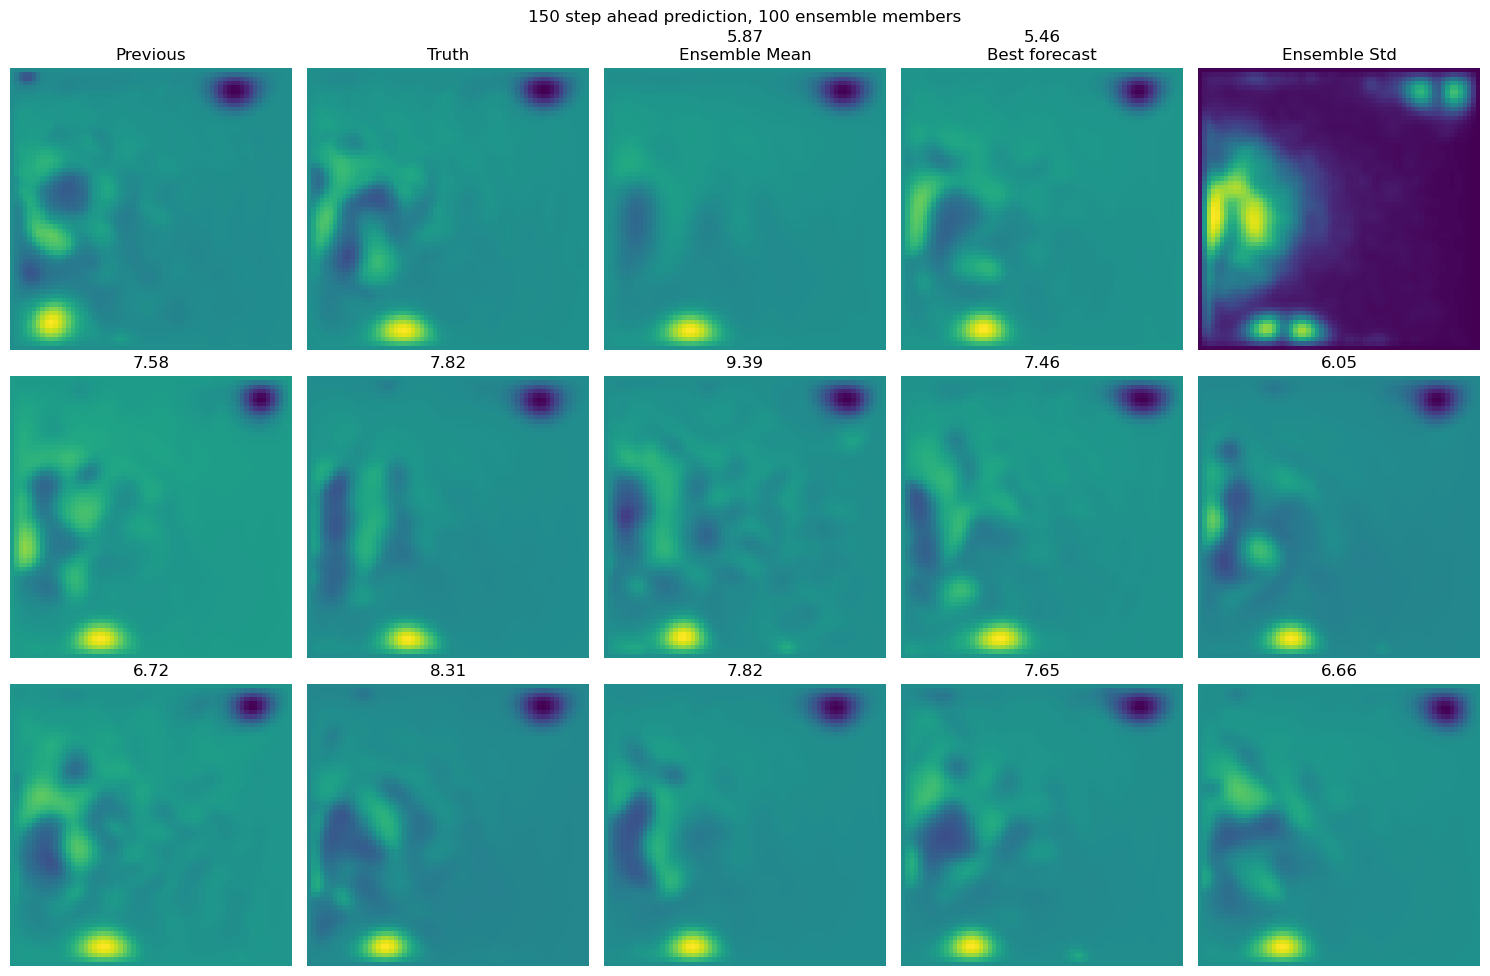

In [219]:
def ensemble_plot(model, selected_loader=shuffled_val_loader, n_ens=10, sampler_fn=edm_sampler):
    
    predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens, selected_loader, sampler_fn=sampler_fn)

    ensemble_mean = predicted_unnormalized.mean(dim=0, keepdim=True)
    ensemble_rmses = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
    ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
    ensemble_std = predicted_unnormalized.std(dim=0)

    best_forecast = predicted_unnormalized[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    def plot_image(ax, image, title):
        image = image.cpu().detach().numpy().reshape((65,65))
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')

    plt.set_cmap('viridis')
    no_ens_rows = 2

    fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
    fig.suptitle(f'{k} step ahead prediction, {n_ens} ensemble members')

    plot_image(axes[0,0], previous_unnormalized, "Previous")
    plot_image(axes[0,1], current_unnormalized, "Truth")
    plot_image(axes[0,2], ensemble_mean, f"{ensemble_skill:.2f}\nEnsemble Mean")
    plot_image(axes[0,3], best_forecast, f"{best_rmse:.2f}\nBest forecast")
    plot_image(axes[0,4], ensemble_std, "Ensemble Std")

    count = 0
    for i in range(no_ens_rows):
        for j in range(5):
            plot_image(axes[1+i,j], predicted_unnormalized[count], f"{ensemble_rmses[count]:.2f}")
            count+=1
    
    plt.tight_layout()
    plt.show()
    
    return ensemble_rmses, ensemble_skill

k = 150


val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
shuffled_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


#ensemble_rmses, ensemble_skill = ensemble_plot(model, selected_loader=val_loader, n_ens=10, sampler_fn=edm_sampler)
ensemble_rmses, ensemble_skill = ensemble_plot(model, selected_loader=shuffled_val_loader, n_ens=100, sampler_fn=heun_sampler)


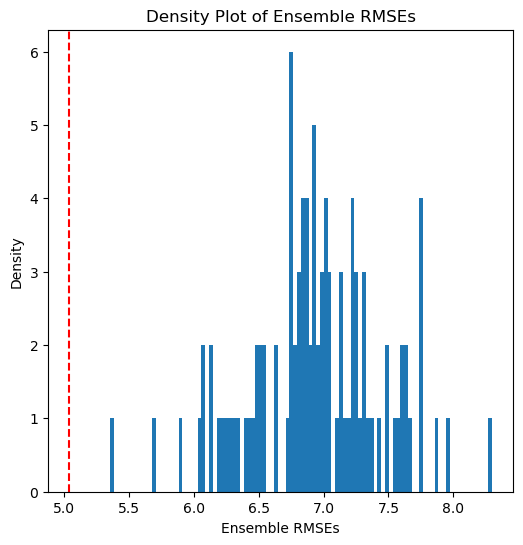

In [20]:
def rmse_density_plot(ensemble_rmses, ensemble_skill):
    plt.figure(figsize=(6,6))
    plt.hist(ensemble_rmses, bins=100)
    plt.axvline(ensemble_skill, color='red', linestyle='--')
    plt.xlabel('Ensemble RMSEs')
    plt.ylabel('Density')
    plt.title('Density Plot of Ensemble RMSEs')
    plt.show()

rmse_density_plot(ensemble_rmses, ensemble_skill)

### 24-04-10

In [46]:
def generate_ensembles(n_ens, n_batches, selected_loader=val_loader):
    model.eval()

    ensembles = []
    truths = []

    with torch.no_grad():
        for count, (previous, current) in enumerate(tqdm(selected_loader, total=n_batches)):
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, n_ens=n_ens, sampler_fn=edm_sampler)
            current_unnormalized = current * std_data + mean_data

            ensembles.append(predicted_unnormalized)
            truths.append(current_unnormalized)

    ensembles = torch.cat(ensembles, dim=1)
    truths = torch.cat(truths, dim=0)
    return ensembles, truths

k = 100

batch_size=128
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

n_ens = 10
n_batches = 10

ensembles, truths = generate_ensembles(n_ens, n_batches, selected_loader=val_loader)

100%|██████████| 10/10 [05:39<00:00, 33.99s/it]


In [22]:
# Rank Histogram

def calculate_rank(predicted, target):
    ranks = (target[None, :] < predicted).sum(axis=0)
    return ranks

def rank_histogram(pixel, ensembles, truths):

    pixel_x, pixel_y = pixel
    
    ensemble = ensembles[:, :, 0, pixel_x, pixel_y]
    target = truths[:, 0, pixel_x, pixel_y]

    rank = calculate_rank(ensemble, target)

    return rank.cpu().detach().numpy()

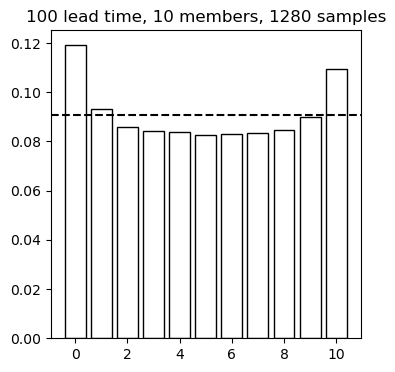

In [62]:
ranks = np.zeros(n_ens+1)
for i in range(10, 65-10):
    for j in range(10, 65-10):
        pixel = (i,j)
        rank = rank_histogram(pixel, ensembles, truths)
        freq = np.bincount(rank, minlength=n_ens+1)
        ranks += freq


plt.figure(figsize=(4,4))
plt.title(f'{k} lead time, {n_ens} members, {n_batches*batch_size} samples')
plt.bar(np.arange(n_ens+1), ranks/(sum(ranks)), facecolor='white', edgecolor='black')
plt.axhline(1/(n_ens+1), color='k', linestyle='--')

(5, 5)


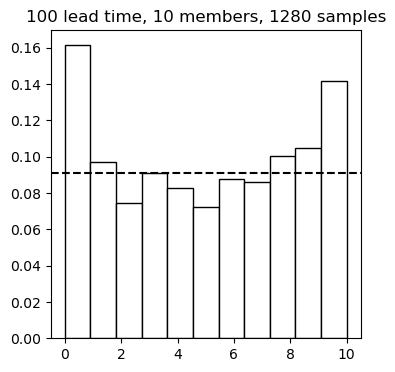

In [58]:
pixel = (np.random.randint(0, 65), np.random.randint(0, 65))
print(pixel)
pixel = (1,33)
ranks = rank_histogram(pixel, ensembles, truths)

plt.figure(figsize=(4,4))
plt.title(f'{k} lead time, {n_ens} members, {n_batches*batch_size} samples')
plt.hist(ranks, bins=n_ens+1, facecolor='white', edgecolor='black', density=True)
plt.axhline(1/(n_ens+1), color='k', linestyle='--')

### 24-04-11

Spread vs time

In [47]:

model.eval()  # Set model to evaluation mode

n_ens = 100

with torch.no_grad():
    for previous, current in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break



ensembles = []
with torch.no_grad():
    for i in range(n_ens):    
        latents = torch.randn_like(class_labels, device=device)

        predicted_residuals = edm_sampler(model, latents, class_labels, time_labels/kmax, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)


<Figure size 640x480 with 0 Axes>

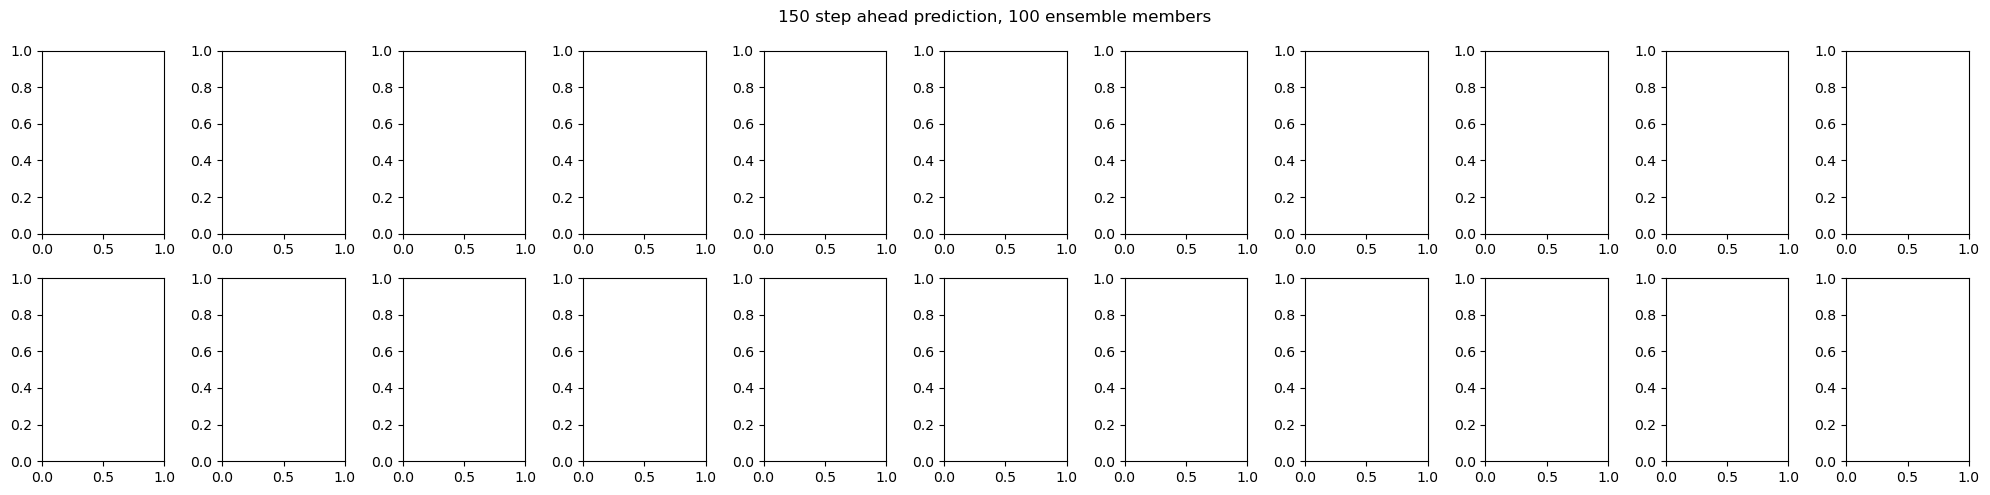

In [48]:

def plot_image(ax, image, title=None):
    image = image.cpu().detach().numpy().reshape((65,65))
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

plt.set_cmap('viridis')

fig, axes = plt.subplots(2,11, figsize=(20,5))
fig.suptitle(f'{k} step ahead prediction, {n_ens} ensemble members')


ks = np.arange(kmin, kmax+1, 1)

torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)


spreads = []
skills = []

for i in range(len(ks)):
    truth = current_unnormalized[(ks[i]-kmin)//d]
    predicted = ens_mean[(ks[i]-kmin)//d]
    #predicted = ensembles[3, ks[i]-kmin]
    ensemble = ensembles[:, (ks[i]-kmin)//d]

    #plot_image(axes[0,i], truth, f"{ks[i]}")
   # plot_image(axes[1,i], predicted, f"{calculate_RMSE(truth.unsqueeze(0), predicted.unsqueeze(0)).item():.2f}")

    skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
    spreads.append(spread[0])
    skills.append(skill[0])

plt.tight_layout()
plt.show()

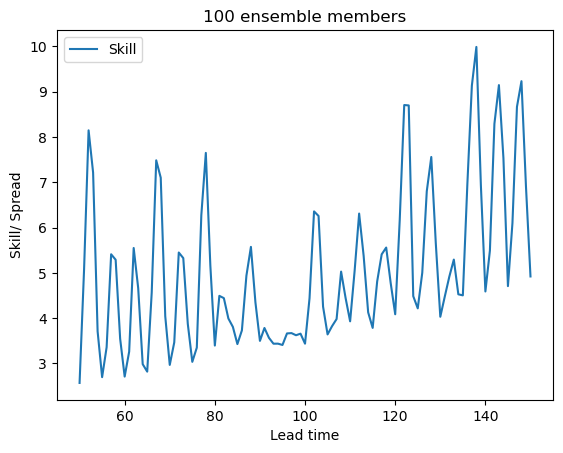

In [50]:
plt.figure()
plt.title(f'{n_ens} ensemble members')
plt.xlabel('Lead time')
plt.ylabel('Skill/ Spread')
#plt.plot(ks, uniform_filter1d(spreads, size=1), label='Spread')
plt.plot(ks, uniform_filter1d(skills, size=1), label='Skill')#, linewidth=0, marker='.')

plt.legend()

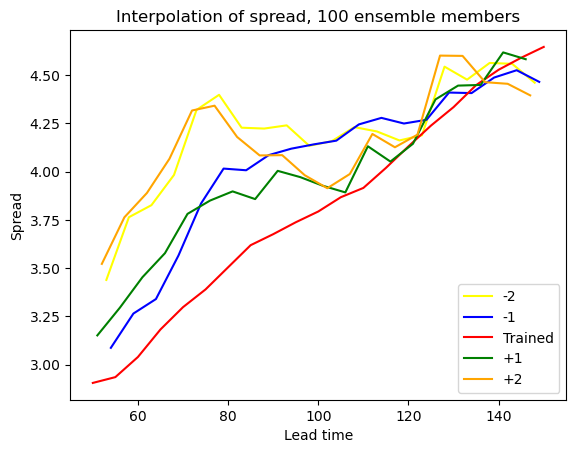

In [52]:
# Assuming 'skills' is the original dataset
ks = np.arange(kmin, kmax+1, 1)
odd_dataset = spreads[::5]  # Select elements with odd indices
even_dataset = spreads[:]  # Select elements with even indices
even_dataset_1 = spreads[1::5]  # Select elements with even indices
even_dataset_2 = spreads[2::5]  # Select elements with even indices
even_dataset_3 = spreads[3::5]  # Select elements with even indices
even_dataset_4 = spreads[4::5]  # Select elements with even indices

plt.figure()
plt.title(f'Interpolation of spread, {n_ens} ensemble members')
plt.plot(ks[3::5], uniform_filter1d(even_dataset_3, 5), label='-2', color='yellow')
plt.plot(ks[4::5], uniform_filter1d(even_dataset_4, 5), label='-1', color='blue')
plt.plot(ks[::5], uniform_filter1d(odd_dataset, 5), label='Trained', color='red')
#plt.plot(ks, uniform_filter1d(even_dataset,1), label='Even')
plt.plot(ks[1::5], uniform_filter1d(even_dataset_1, 5), label='+1', color='green')
plt.plot(ks[2::5], uniform_filter1d(even_dataset_2, 5), label='+2', color='orange')

plt.xlabel('Lead time')
plt.ylabel('Spread')

plt.legend()

plt.show()

Linear interpolation

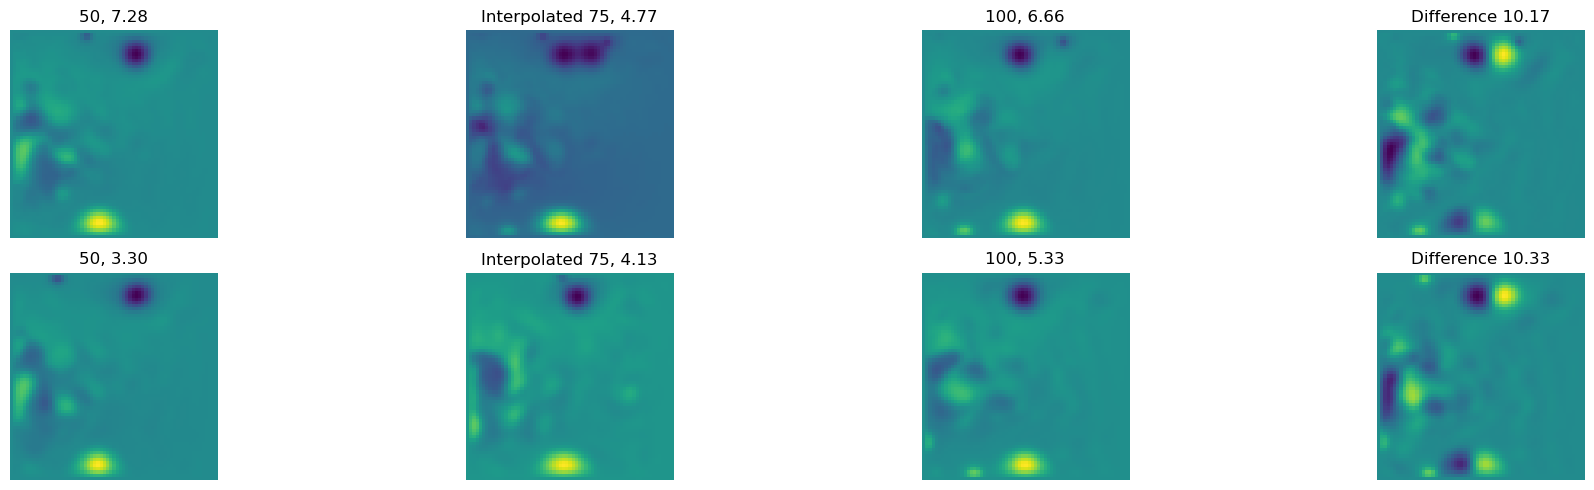

In [151]:
fig, axes = plt.subplots(2,4, figsize=(20,5))

dk = 50
idx = 0 #np.random.randint(0, 100-dk)

first = current_unnormalized[idx,0].cpu().detach().numpy()
third = current_unnormalized[idx+dk,0].cpu().detach().numpy()

second_truth = current_unnormalized[idx+dk//2,0].cpu().detach().numpy()

alpha = 0.5
second = (1-alpha)*first + alpha * third

# Model
rdx = np.random.randint(0, n_ens)
first_model = ensembles[rdx, idx, 0].cpu().detach().numpy()
third_model = ensembles[rdx, idx+dk, 0].cpu().detach().numpy()

second_model = ensembles[rdx, idx+dk//2, 0].cpu().detach().numpy()
#second_model = (1-alpha)*first_model + alpha * third_model

axes[0,0].imshow(first)
axes[0,0].set_title(f'{ks[idx]}, {np.sqrt(np.mean((first - second_truth)**2)):.2f}')
axes[0,0].axis('off')

axes[0,1].imshow(second)
axes[0,1].set_title(f'Interpolated {ks[idx+dk//2]}, {np.sqrt(np.mean((second - second_truth)**2)):.2f}')
axes[0,1].axis('off')

axes[0,2].imshow(third)
axes[0,2].set_title(f'{ks[idx+dk]}, {np.sqrt(np.mean((third - second_truth)**2)):.2f}')
axes[0,2].axis('off')

axes[0,3].imshow(third - first)
axes[0,3].set_title(f'Difference {np.sqrt(np.mean((third - first)**2)):.2f}')
axes[0,3].axis('off')


# Model

axes[1,0].imshow(first_model)
axes[1,0].set_title(f'{ks[idx]}, {np.sqrt(np.mean((first_model - first)**2)):.2f}')
axes[1,0].axis('off')

axes[1,1].imshow(second_model)
axes[1,1].set_title(f'Interpolated {ks[idx+dk//2]}, {np.sqrt(np.mean((second_model - second_truth)**2)):.2f}')
axes[1,1].axis('off')

axes[1,2].imshow(third_model)
axes[1,2].set_title(f'{ks[idx+dk]}, {np.sqrt(np.mean((third_model - third)**2)):.2f}')
axes[1,2].axis('off')

axes[1,3].imshow(third_model - first_model)
axes[1,3].set_title(f'Difference {np.sqrt(np.mean((third_model - first_model)**2)):.2f}')
axes[1,3].axis('off')

plt.tight_layout()





New idea based on adding gaussians

In [220]:
model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

<Figure size 640x480 with 0 Axes>

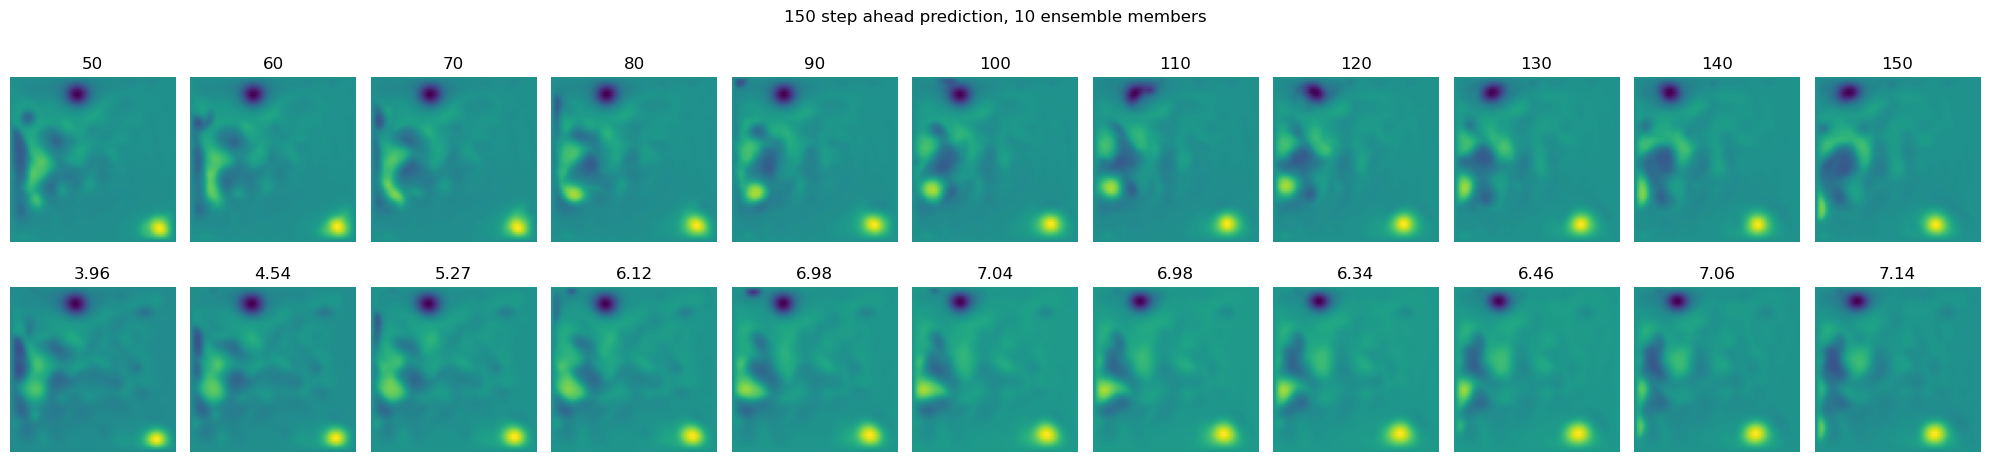

In [290]:

n_ens = 10


ensembles = []
with torch.no_grad():
    for i in range(n_ens):    
        #latents = torch.randn_like(class_labels, device=device)
        latents = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)

        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/kmax, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)


def plot_image(ax, image, title=None):
    image = image.cpu().detach().numpy().reshape((65,65))
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

plt.set_cmap('viridis')

num_figs = 11
fig, axes = plt.subplots(2,num_figs, figsize=(20,5))
fig.suptitle(f'{k} step ahead prediction, {n_ens} ensemble members')


#ks = np.arange(kmin, kmax+1, 20)

dk = 10
ks = np.arange(kmin, kmin+dk*num_figs, dk)

torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)


spreads = []
skills = []

for i in range(len(ks)):
    truth = current_unnormalized[(ks[i]-kmin)//d]
    predicted = ens_mean[(ks[i]-kmin)//d]
    predicted = ensembles[0, (ks[i]-kmin)//d]
    ensemble = ensembles[:, (ks[i]-kmin)//d]

    plot_image(axes[0,i], truth, f"{ks[i]}")
    plot_image(axes[1,i], predicted, f"{calculate_RMSE(truth.unsqueeze(0), predicted.unsqueeze(0)).item():.2f}")

    skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
    spreads.append(spread[0])
    skills.append(skill[0])

plt.tight_layout()
plt.show()

In [348]:
truth = current_unnormalized[:, 0, :, :].cpu().detach().numpy()
forecasts = ensembles[:, :, 0, :, :].cpu().detach().numpy()
mean_forecast = forecasts.mean(axis=0)
stds = forecasts.std(axis=0)

In [ ]:
%matplotlib inline

from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')


#fig, axes = plt.subplots(3,3, figsize=(5,5.5), constrained_layout=True)
fig, axes = plt.subplots(2,3, figsize=(10,7), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        images.append(ax.imshow(truth[0]))
    elif i == 1:
        images.append(ax.imshow(stds[0]))
    elif i == 2:
        images.append(ax.imshow(mean_forecast[0]))
    else:
        images.append(ax.imshow(forecasts[i-3,0]))

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(stds[n])
        elif i == 2:
            im.set_array(mean_forecast[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text('k = {0:4d}'.format(n+kmin))
    title1.set_text('Truth')
    title2.set_text('Std')
    title3.set_text('Mean')

    return images

#plt.tight_layout(rect=[0, 0, 1, 0.95])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=101, interval=50, blit=True)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

KNN

In [ ]:
# KNN

# Fixed k sampling
training_size =200000 #1679900
batch_size = 256
n_ens = 100

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, 'cpu')
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, 'cpu')

train_loader = DataLoader(train_dataset, batch_size=training_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

shuffled_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

from sklearn.neighbors import KNeighborsRegressor

for previous_train, current_train in train_loader:
    previous_train = previous_train.view(previous_train.shape[0],-1) * std_data + mean_data
    current_train = current_train.view(previous_train.shape[0],-1) * std_data + mean_data
    break

knn = KNeighborsRegressor(n_neighbors=n_ens, weights='distance')
knn.fit(previous_train, current_train)


In [ ]:
batch_size = 100

val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, 'cpu')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for previous_val_unnorm, current_val in val_loader:
    previous_val = previous_val_unnorm.view(previous_val_unnorm.shape[0],-1) * std_data + mean_data
    current_val = current_val.view(previous_val.shape[0],-1) * std_data + mean_data
    break

Y_pred = knn.predict(previous_val).astype('float32')

neigh_dist, neigh_ind = knn.kneighbors(previous_val)
ens_pred = current_train[neigh_ind]

ens_pred = ens_pred.permute(1,0,2).reshape(ens_pred.shape[1],ens_pred.shape[0], 1, 65,65)
current_val = current_val.view(batch_size, 1, 65, 65)

In [ ]:
n_ens = 10
predicted_unnormalized = generate_ensemble_from_batch(model, previous_val_unnorm.to(device), n_ens=n_ens, sampler_fn=edm_sampler)

In [ ]:
batch_size = 100
n_batches = 10

val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, 'cpu')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model_skill, model_spread = [], []

with torch.no_grad():
    for count, (previous, current) in enumerate(tqdm(val_loader, total=n_batches)):
        if count >= n_batches:
            break
        
        previous = previous.to(device)
        current = current.to(device)
        
        predicted_unnormalized = generate_ensemble_from_batch(model, previous.to(device), n_ens=n_ens, sampler_fn=edm_sampler)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        ensemble_mean = predicted_unnormalized.mean(dim=0)

        model_skills, model_spreads, _ = calculate_skill_and_spread_score(predicted_unnormalized, current_unnormalized)

        model_skill.append(model_skills)
        model_spread.append(model_spreads)

model_skill = np.concatenate(model_skill)
model_spread = np.concatenate(model_spread)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:05<00:00, 24.58s/it]


In [ ]:
truth = current_val

forecast_knn = ens_pred
forecast_model = predicted_unnormalized.to('cpu')

knn_skill, knn_spread, _ = calculate_skill_and_spread_score(forecast_knn, truth)
#model_skill, model_spread, _ = calculate_skill_and_spread_score(forecast_model, truth)

print(f'KNN Skill: {knn_skill[0].item():.2f}, Spread: {knn_spread[0].item():.2f}')
print(f'Model Skill: {model_skill[0].item():.2f}, Spread: {model_spread[0].item():.2f}')

KNN Skill: 8.19, Spread: 7.91
Model Skill: 5.27, Spread: 4.48


In [ ]:

running_mean=100
key = 'spread'

#x = np.arange(0, len(nwp_skill))

fig, axes = plt.subplots(1,1, figsize=(12,5))

ax1 = axes
ax2 = ax1.twinx()
ax1.set_title(f'Model {key} vs RMSE NWP')

ax1.plot(uniform_filter1d(knn_spread, size=running_mean), color='blue', label='KNN Spread')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')

ax2.set_ylabel(f'Model {key}')
ax2.plot(uniform_filter1d(model_spread, size=running_mean), color='red', label=f'Model Spread')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



In [ ]:
knn_std = forecast_knn.std(dim=0)
model_std = forecast_model.std(dim=0)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))

idx = np.random.randint(0, batch_size)
kdx = np.random.randint(0, 10)
rdx = np.random.randint(0, 10)

forecast_kn = forecast_knn[kdx,idx].reshape(65, 65)
forecast_pred = Y_pred[idx].reshape(65, 65)
forecast_diff = forecast_model[rdx, idx, 0].to('cpu')
truth = current_val[idx,0].reshape(65, 65)
knn_std_img = knn_std[idx].reshape(65, 65)
model_std_img = model_std[idx].reshape(65, 65)

axes[0,0].imshow(forecast_kn)
axes[0,0].set_title('KNN Prediction')
axes[0,0].axis('off')

axes[0,1].imshow(truth)
axes[0,1].set_title('Truth')
axes[0,1].axis('off')

axes[0,2].imshow(forecast_diff)
axes[0,2].set_title('Model Prediction')
axes[0,2].axis('off')

axes[1,0].imshow(knn_std_img)
axes[1,0].set_title('KNN Std')
axes[1,0].axis('off')

axes[1,1].imshow(model_std_img)
axes[1,1].set_title('Model Std')
axes[1,1].axis('off')

axes[1,2].imshow(forecast_pred)
axes[1,2].set_title('KNN Avg Prediction')
axes[1,2].axis('off')

### MISC

In [ ]:
predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=1000, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)

rmse_ensemble = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
mae_ensemble = calculate_MAE(predicted_unnormalized, current_unnormalized).flatten()

ensemble_mean = predicted_unnormalized.mean(dim=0)

rmse_to_mean = calculate_RMSE(predicted_unnormalized, ensemble_mean).flatten()
mae_to_mean = calculate_MAE(predicted_unnormalized, ensemble_mean).flatten()

ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
ensemble_mean_mae = calculate_MAE(ensemble_mean, current_unnormalized).item()


In [ ]:
from scipy import stats

stats.mode(rmse_ensemble)

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
bins= 30
axes[0,0].hist2d(rmse_to_mean, rmse_ensemble, bins=bins, cmap='Blues')
axes[0,0].set_xlabel('RMSE to Mean')
axes[0,0].set_ylabel('RMSE of Members')
axes[0,0].set_title('RMSE to Mean vs RMSE of Members')
axes[0,0].hlines(ensemble_skill, min(rmse_to_mean), max(rmse_to_mean), color='red', linestyle='--')
axes[0,0].hlines(np.mean(rmse_ensemble), min(rmse_to_mean), max(rmse_to_mean), color='green', linestyle='--')

axes[0,1].hist2d(mae_to_mean, rmse_ensemble, bins=bins, cmap='Blues')
axes[0,1].set_xlabel('MAE to Mean')
axes[0,1].set_ylabel('RMSE of Members')
axes[0,1].set_title('MAE to Mean vs RMSE of Members')
axes[0,1].hlines(ensemble_skill, min(mae_to_mean), max(mae_to_mean), color='red', linestyle='--')
axes[0,1].hlines(np.mean(rmse_ensemble), min(mae_to_mean), max(mae_to_mean), color='green', linestyle='--')

axes[1,0].hist2d(rmse_to_mean, mae_ensemble, bins=bins, cmap='Blues')
axes[1,0].set_xlabel('RMSE to Mean')
axes[1,0].set_ylabel('MAE of Members')
axes[1,0].set_title('RMSE to Mean vs MAE of Members')
axes[1,0].hlines(ensemble_mean_mae, min(rmse_to_mean), max(rmse_to_mean), color='red', linestyle='--')
axes[1,0].hlines(np.mean(mae_ensemble), min(rmse_to_mean), max(rmse_to_mean), color='green', linestyle='--')

axes[1,1].hist2d(mae_to_mean, mae_ensemble, bins=bins, cmap='Blues')
axes[1,1].set_xlabel('MAE to Mean')
axes[1,1].set_ylabel('MAE of Members')
axes[1,1].set_title('MAE to Mean vs MAE of Members')
axes[1,1].hlines(ensemble_mean_mae, min(mae_to_mean), max(mae_to_mean), color='red', linestyle='--')
axes[1,1].hlines(np.mean(mae_ensemble), min(mae_to_mean), max(mae_to_mean), color='green', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:


fig, axes = plt.subplots(2,2, figsize=(10, 10))

axes[0,0].scatter(rmse_to_mean, rmse_ensemble, alpha=0.5)
axes[0,0].set_xlabel('RMSE to Mean')
axes[0,0].set_ylabel('RMSE of Members')
axes[0,0].set_title('RMSE to Mean vs RMSE of Members')
axes[0,0].hlines(ensemble_skill, min(rmse_to_mean), max(rmse_to_mean), color='red', linestyle='--')
axes[0,0].hlines(np.mean(rmse_ensemble), min(rmse_to_mean), max(rmse_to_mean), color='green', linestyle='--')

axes[0,1].scatter(mae_to_mean, rmse_ensemble, alpha=0.5)#, s=10, marker='o')
axes[0,1].set_xlabel('MAE to Mean')
axes[0,1].set_ylabel('RMSE of Members')
axes[0,1].set_title('MAE to Mean vs RMSE of Members')
axes[0,1].hlines(ensemble_skill, min(mae_to_mean), max(mae_to_mean), color='red', linestyle='--')
axes[0,1].hlines(np.mean(rmse_ensemble), min(mae_to_mean), max(mae_to_mean), color='green', linestyle='--')


axes[1,0].scatter(rmse_to_mean, mae_ensemble, alpha=0.5)
axes[1,0].set_xlabel('RMSE to Mean')
axes[1,0].set_ylabel('MAE of Members')
axes[1,0].set_title('RMSE to Mean vs MAE of Members')
axes[1,0].hlines(ensemble_mean_mae, min(rmse_to_mean), max(rmse_to_mean), color='red', linestyle='--')
axes[1,0].hlines(np.mean(mae_ensemble), min(rmse_to_mean), max(rmse_to_mean), color='green', linestyle='--')


axes[1,1].scatter(mae_to_mean, mae_ensemble, alpha=0.5)
axes[1,1].set_xlabel('MAE to Mean')
axes[1,1].set_ylabel('MAE of Members')
axes[1,1].set_title('MAE to Mean vs MAE of Members')
axes[1,1].hlines(ensemble_mean_mae, min(mae_to_mean), max(mae_to_mean), color='red', linestyle='--')
axes[1,1].hlines(np.mean(mae_ensemble), min(mae_to_mean), max(mae_to_mean), color='green', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=500, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)

rmse_ensemble = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
mae_ensemble = calculate_MAE(predicted_unnormalized, current_unnormalized).flatten()

ensemble_mean = predicted_unnormalized.mean(dim=0)

rmse_to_mean = calculate_RMSE(predicted_unnormalized, ensemble_mean).flatten()
mae_to_mean = calculate_MAE(predicted_unnormalized, ensemble_mean).flatten()

ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
ensemble_mean_mae = calculate_MAE(ensemble_mean, current_unnormalized).item()


rand_idx = np.random.randint(0, n_ens)
rand_idx = np.argmin(mae_to_mean)

best_idx = np.argmin(mae_ensemble)
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

axes[0].imshow(current_unnormalized[0,0].cpu().detach().numpy())
axes[0].set_title('Truth')
axes[0].axis('off')
axes[1].imshow(predicted_unnormalized[rand_idx,0,0].cpu().detach().numpy())
axes[1].set_title('Closest to mean')
axes[1].axis('off')
axes[2].imshow(predicted_unnormalized.mean(dim=0)[0,0].cpu().detach().numpy())
axes[2].set_title('Ensemble Mean')
axes[2].axis('off')
axes[4].imshow(predicted_unnormalized.std(dim=0)[0,0].cpu().detach().numpy())
axes[4].set_title('Ensemble Std')
axes[4].axis('off')

axes[3].imshow(predicted_unnormalized[best_idx, 0,0].cpu().detach().numpy())
axes[3].set_title('Best RMSE')
axes[3].axis('off')



plt.tight_layout()


### Evaluation Pipeline

In [ ]:
def evaluation_pipeline(model, n_ens=10, n_batches=1, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    results = {
                'skill': np.zeros(n_batches*batch_size),
                'spread': np.zeros(n_batches*batch_size),
                'ratio': np.zeros(n_batches*batch_size),
                'crps': np.zeros(n_batches*batch_size),
                'brier': np.zeros(n_batches*batch_size),
                'covtrace': np.zeros(n_batches*batch_size)
                }
    
    results['rmse'] = np.zeros((n_ens, n_batches*batch_size))

    with torch.no_grad():
        for count, (previous, current) in (enumerate(tqdm(selected_loader))):
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, n_ens=n_ens)

            current_unnormalized = current * std_data + mean_data

            rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized)

            skill, spread, ratio = calculate_skill_and_spread_score(predicted_unnormalized, current_unnormalized)
            #crps = calculate_CRPS(predicted_unnormalized, current_unnormalized)
            #brier = calculate_brier_score(predicted_unnormalized, current_unnormalized, 20)
            #covtrace = calculate_covtrace(predicted_unnormalized)
            
            # Can make this easier by preallocating results
            results['skill'][count*batch_size:(count+1)*batch_size] = skill
            results['spread'][count*batch_size:(count+1)*batch_size] = spread
            results['ratio'][count*batch_size:(count+1)*batch_size] = ratio
            #results['crps'][count*batch_size:(count+1)*batch_size] = crps
            #results['brier'][count*batch_size:(count+1)*batch_size] = brier
            #results['covtrace'][count*batch_size:(count+1)*batch_size] = covtrace

            results['rmse'][:,count*batch_size:(count+1)*batch_size] = rmse

    return results

#res = evaluation_pipeline(model, n_ens=3, n_batches=2, selected_loader=val_loader, sampler_fn=edm_sampler)

### Various Time Series Plots

In [ ]:
n_batches = 100
n_ens = 100
res = evaluation_pipeline(model, n_ens=n_ens, n_batches=n_batches, selected_loader=val_loader, sampler_fn=edm_sampler)

skill, spread, ratio, crps, brier, rmse, covtrace = res['skill'], res['spread'], res['ratio'], res['crps'], res['brier'], res['rmse'], res['covtrace']

nwp_skill = calculate_nwp_skill(n_batches=n_batches)

In [ ]:
# Basic Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(res['skill'], label='Skill', color='blue')
axes[0].set_title('Skill and Spread Scores')
axes[0].plot(res['spread'], label='Spread', color='red')
axes[0].legend()

axes[2].plot(res['ratio'], label='Ratio', color='green')
axes[2].set_title('Ratio')

axes[1].plot(res['crps'], label='CRPS', color='purple')
axes[1].set_title('CRPS')

axes[2].plot(res['brier'], label='Brier', color='orange')
axes[2].set_title('Brier')

plt.tight_layout()

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
running_mean=50
axes.plot(uniform_filter1d(res['skill'], size=running_mean), label='Skill', color='blue')
axes.set_title(f'Forecasting {k} steps ahead, {n_ens} ensemble members')
axes.plot(uniform_filter1d(res['spread'], size=running_mean), label='Spread', color='red')
axes.legend()

In [ ]:
plt.figure(figsize=(15,5))
running_mean=50
# Calculate the mean and standard deviation of rmse_model
mean_rmse = np.mean(rmse, axis=0)
std_rmse = np.std(rmse, axis=0)
min_rmse = np.min(rmse, axis=0)
max_rmse = np.max(rmse, axis=0)
plt.title(f'Forecasting {k} steps ahead, {n_ens} ensemble members')

# Plot the mean line
plt.plot(uniform_filter1d(mean_rmse, size=running_mean), label='Mean RMSE', color='blue')

# Plot the standard deviation band
plt.fill_between(range(len(mean_rmse)), uniform_filter1d(mean_rmse - std_rmse, size=running_mean), uniform_filter1d(mean_rmse + std_rmse, size=running_mean), alpha=0.2, color='green', label="1 std")
plt.fill_between(range(len(mean_rmse)), uniform_filter1d(min_rmse, size=running_mean), uniform_filter1d(max_rmse, size=running_mean), alpha=0.2, color='blue', label="min-max")
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('RMSE')

# Show the plot

#plt.plot(rmse_model, label='RMSE Model', linewidth=0.05)
#plt.plot(uniform_filter1d(nwp_skill, size=running_mean), label='RMSE NWP', color='r')
#plt.plot(var_model, label='Var Model', color='g')
plt.plot(uniform_filter1d(skill, size=running_mean), label='Skill', color='m')
plt.plot(spread, label='Spread', color='y')
#plt.plot(crps, label='CRPS Model', color='c')
#plt.plot(brier, label='Brier Model', color='k')
plt.legend()
plt.show()

In [ ]:

key = 'spread'
running_mean = 1
x = np.arange(0, len(nwp_skill))

fig, axes = plt.subplots(1,2, figsize=(15,5))

ax1 = axes[0]
ax2 = ax1.twinx()
ax1.set_title(f'Model {key} vs RMSE NWP')

ax1.plot(uniform_filter1d(nwp_skill, size=running_mean), color='blue', label='RMSE NWP')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')

ax2.set_ylabel(f'Model {key}')
ax2.plot(uniform_filter1d(res[key], size=running_mean), color='red', label=f'Model {key}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax3 = axes[1]
ax3.plot(uniform_filter1d(res[key], size=running_mean), uniform_filter1d(nwp_skill, size=running_mean), marker='.', linestyle='')
ax3.set_title(f'Model {key} vs RMSE NWP')
ax3.set_xlabel(f'Model {key}')
ax3.set_ylabel('RMSE NWP')

plt.tight_layout()
plt.show()


In [ ]:
running_mean=10
key = 'spread'

x = np.arange(0, len(nwp_skill))

fig, axes = plt.subplots(1,1, figsize=(12,5))

ax1 = axes
ax2 = ax1.twinx()
ax1.set_title(f'Model {key} vs RMSE NWP')

ax1.plot(uniform_filter1d(nwp_skill, size=running_mean), color='blue', label='RMSE NWP')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')

ax2.set_ylabel(f'Model {key}')
ax2.plot(uniform_filter1d(res[key], size=running_mean), color='red', label=f'Model {key}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Likelihood

#### Generate first then estimate

In [ ]:
def generate_complete_solution_from_single_random(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=complete_edm_sampler, num_steps=20):
    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0)
        current_unbatched = current[0].unsqueeze(0)
        break


    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)
        
        predicted_residuals, predicted_residuals_list = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=num_steps, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * std_residual_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, latents, predicted_residuals_list, current_unnormalized, class_labels

torch.manual_seed(0)
num_steps = 20
n_ens = 10
predicted_unnormalized, latents, predicted_residuals_list, current_unnormalized, class_labels = generate_complete_solution_from_single_random(model, n_ens=n_ens, selected_loader = shuffled_val_loader, sampler_fn=complete_edm_sampler, num_steps=num_steps)

In [ ]:
def likelihood_estimation(model, samples, latents, sample_list, class_labels, eps_multiplier=1, num_steps=20):
    res_list = {}

    ensemble_rmses = calculate_RMSE(samples, current_unnormalized).flatten()

    res = {}
    for j in tqdm(range(n_ens)):
        
        latent = latents[j].unsqueeze(0)
        sample = sample_list[:,j].unsqueeze(1)
        class_label = class_labels[j].unsqueeze(0)

        likelihood = likelihood_estimator(model, 
                                latent,
                                sample, 
                                class_label,
                                eps_multiplier=eps_multiplier,
                                num_steps=num_steps,
                                sigma_max=80, sigma_min=0.03, rho=7, 
                                S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05).item()
        
        print(likelihood, ensemble_rmses[j])
        
        res[np.round(ensemble_rmses[j],3)] = likelihood
            
    sorted_keys = sorted(res.keys())
    sorted_data = [res[key] for key in sorted_keys]

    #plt.boxplot(sorted_data, labels=sorted_keys)
    plt.plot(sorted_keys, sorted_data, marker='o', linewidth=0)

    plt.show()

    return res

res = likelihood_estimation(model, predicted_unnormalized, latents, predicted_residuals_list, class_labels, eps_multiplier=10, num_steps=num_steps)

#### Estimate And Generate

OBS: We can not do the same boxplots as before since we sample at the same time as calculating likelihood
And also not evaluate the effect of eps_multiplier

In [ ]:
def generate_and_estimate_likelihood(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=likelihood_sampler, num_steps=20, eps_multiplier=1):

    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0)
        current_unbatched = current[0].unsqueeze(0)
        break

    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)

        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

    predicted_unnormalized_ensemble = torch.zeros((n_ens, 1, previous.size(1), previous.size(2), previous.size(3)), device=device)
    likelihood_ensemble = np.zeros(n_ens)
    rmse_ensemble = np.zeros(n_ens)
    mae_ensemble = np.zeros(n_ens)

    for j in tqdm(range(n_ens)):
        with torch.no_grad():
            latent = latents[j].unsqueeze(0)
            class_label = class_labels[j].unsqueeze(0)

            predicted_residuals, likelihood  = sampler_fn(model, 
                                    latent, 
                                    class_label,
                                    eps_multiplier=eps_multiplier,
                                    num_steps=num_steps,
                                    sigma_max=80, sigma_min=0.03, rho=7, 
                                    S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            
            predicted_latent = previous_latent + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unnormalized = predicted * std_data + mean_data
            predicted_unnormalized_ensemble[j] = predicted_unnormalized
            likelihood_ensemble[j] = likelihood.item()

            # ----
            ensemble_rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
            ensemble_mae = calculate_MAE(predicted_unnormalized, current_unnormalized).flatten()
            
            rmse_ensemble[j] = ensemble_rmse.item()
            mae_ensemble[j] = ensemble_mae.item()
            print(f"Likelihood {j}: {likelihood.item():.0f}, RMSE {j}: {rmse_ensemble[j]:.2f}, MAE {j}: {mae_ensemble[j]:.2f}")
        
    return predicted_unnormalized_ensemble, current_unnormalized, likelihood_ensemble, rmse_ensemble, mae_ensemble

In [ ]:
n_ens = 100
eps_multiplier = 20
num_steps = 20

#predicted_unnormalized_ensemble, current_unnormalized, likelihood_ensemble, rmse_ensemble, mae_ensemble = generate_and_estimate_likelihood(model, n_ens=n_ens, selected_loader = shuffled_val_loader, sampler_fn=likelihood_sampler, num_steps=num_steps, eps_multiplier=eps_multiplier)

plt.figure(figsize=(6,6))
plt.xlabel('MAE')
plt.ylabel('Likelihood')
plt.title('Likelihood vs RMSE')
plt.plot(rmse_ensemble, -likelihood_ensemble, marker='o', linestyle='')

In [ ]:
rmse_to_mean = calculate_RMSE(predicted_unnormalized_ensemble, predicted_unnormalized_ensemble.mean(dim=0)).flatten()
mae_to_mean = calculate_MAE(predicted_unnormalized_ensemble, predicted_unnormalized_ensemble.mean(dim=0)).flatten()

In [ ]:
plt.plot(rmse_to_mean, rmse_ensemble, marker='o', linestyle='')

In [ ]:
import numpy as np

correlation = np.corrcoef(mae_to_mean, rmse_ensemble)[0, 1]
correlation


In [ ]:
rand_idx = np.random.randint(0, n_ens)
fig, axes = plt.subplots(1, 4, figsize=(15, 10))

axes[0].imshow(current_unnormalized[0,0].cpu().detach().numpy())
axes[0].set_title('Truth')
axes[0].axis('off')
axes[1].imshow(predicted_unnormalized_ensemble[rand_idx,0,0].cpu().detach().numpy())
axes[1].set_title('Forecast')
axes[1].axis('off')
axes[2].imshow(predicted_unnormalized_ensemble.mean(dim=0)[0,0].cpu().detach().numpy())
axes[2].set_title('Ensemble Mean')
axes[2].axis('off')
axes[3].imshow(predicted_unnormalized_ensemble.std(dim=0)[0,0].cpu().detach().numpy())
axes[3].set_title('Ensemble Std')
axes[3].axis('off')




plt.tight_layout()


In [ ]:
# Sort the forecasts based on likelihood
sorted_indices = np.argsort(likelihood_ensemble)
sorted_forecasts = predicted_unnormalized_ensemble[sorted_indices]

# Plot the sorted forecasts
fig, axes = plt.subplots(20, 5, figsize=(30, 100))

for i, ax in enumerate(axes):
    for j, ax in enumerate(ax):
        ax.imshow(sorted_forecasts[i*4+j, 0, 0].cpu().detach().numpy())
        ax.set_title(f'{likelihood_ensemble[sorted_indices[i]]:.0f}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(mae_ensemble, rmse_ensemble, marker='o', linestyle='')

#### Sampling + Likelihood as in original paper

Slower than current method.

In [ ]:
from likelihood import get_likelihood_fn

for previous, current in val_loader:
    prev = autoencoder.encoder(previous)[0:10]#.unsqueeze(0)
    curr = autoencoder.encoder(current)[0:10]#.unsqueeze(0)
    break

likelihood_fn = get_likelihood_fn(model, atol=10, rtol=0.1)
res = likelihood_fn(model, curr, prev)
A = res[-1,:]

In [ ]:
def generate_forecast_likelihood(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    
    previous = previous.unsqueeze(0)
    previous_latent = autoencoder.encoder(previous)
    
    latents = torch.randn([n_ens, model.img_channels//2, model.img_resolution, model.img_resolution], device=device)
    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
    predicted_latent = class_labels + predicted_residuals * std_residual_latent
    predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
    predicted_unscaled = predicted * std_data + mean_data

    also_sample, logp = likelihood_fn(model, latents, previous_latent)
    also_sample = class_labels + also_sample * std_residual_latent
    also_sample = autoencoder.decoder(also_sample.to(torch.float32))
    also_sample = also_sample * std_data + mean_data

    return predicted_unscaled, also_sample, logp

In [ ]:
res = generate_forecast_likelihood(model, previous[0], n_ens=1)
pred, also_pred, logp = res
print(logp)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pred.detach().cpu().numpy()[0,0])
axes[0].axis('off')
axes[0].set_title('Pred')

axes[1].imshow(also_pred.detach().cpu().numpy()[0,0])
axes[1].axis('off')
axes[1].set_title(f'Also {((also_pred - current[0])**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()}')


axes[2].imshow(current.detach().cpu().numpy()[0,0])
axes[2].axis('off')
axes[2].set_title('Current')
